# FIT5196-S1-2024 Assessment 2

The following notebook provides our answers and working out for Assignment 2 Tasks 1 and 2 for FIT5196 Data Wrangling

Before performing any data cleaning or EDA, we first import necessary libraries

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
from joblib import load
import seaborn as sns
from sklearn import preprocessing

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## Task 1: Data Cleaning

We now import necessary input files for Task 1

In [2]:
dirty_data_path = "Group109_dirty_data.csv"
missing_data_path = "Group109_missing_data.csv"
outlier_data_path = "Group109_outlier_data.csv"
branch_path = "branches.csv"
edges_path = "edges.csv"
nodes_path = "nodes.csv"

dirty_df = pd.read_csv(dirty_data_path)
missing_df = pd.read_csv(missing_data_path)
outlier_df = pd.read_csv(outlier_data_path)
branch_df = pd.read_csv(branch_path)
edges_df = pd.read_csv(edges_path)
nodes_df = pd.read_csv(nodes_path)

### Task 1.1 Detecting and Fixing Errors in dirty_data.csv 

The general approach that we would be following to identify potential dirty data is listed below. We are generally looking for data anomalies related to:
- integrity constraints
- data entry error
- wrong categorical data
- violation of referential integrity
- duplicated data
- go against value range
- wrong encoding
- wrong representations
- wrong names and numbers

To get a broad understanding of the dirty dataset in `dirty_df` we utilise `info()`, `describe()`, and `head()` functions in `pandas` library to understand the data type of each feature, gain more insight into the value range for numerical features and also have a view of what the raw data looks like

In [3]:
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


In [4]:
dirty_df.describe()

order_price  customer_lat  customer_lon  customerHasloyalty?  \
count   500.000000    500.000000    500.000000           500.000000   
mean    480.712900    -30.753946    143.504403             0.102000   
std     254.034843     25.337436     16.299630             0.302951   
min      31.750000    -37.827188    -37.822231             0.000000   
25%     300.625000    -37.818738    144.952786             0.000000   
50%     434.250000    -37.811755    144.963914             0.000000   
75%     633.250000    -37.804505    144.980037             0.000000   
max    1361.500000    145.005221    145.015449             1.000000   

       distance_to_customer_KM  delivery_fee  
count               500.000000    500.000000  
mean                  8.629274     13.877162  
std                   1.596279      2.378285  
min                   3.613000      5.646222  
25%                   7.750500     12.660927  
50%                   8.639500     13.849738  
75%                   9.633500     15.229668  
max                  13.735000     20.088572

In [5]:
dirty_df.head()

order_id        date      time order_type branch_code  \
0  ORDX02948  2018-03-11  10:11:49  Breakfast          BK   
1  ORDC07988  2018-03-06  10:01:41  Breakfast          NS   
2  ORDI00568  2018-07-05  14:05:04      Lunch          NS   
3  ORDI06756  2018-04-23  11:43:05  Breakfast          NS   
4  ORDX01986  2018-04-29  11:53:14  Breakfast          BK   

                                         order_items  order_price  \
0  [('Cereal', 4), ('Eggs', 3), ('Coffee', 1), ('...       206.00   
1  [('Coffee', 2), ('Cereal', 5), ('Eggs', 10), (...       437.00   
2  [('Fries', 6), ('Chicken', 5), ('Salad', 7), (...       507.40   
3       [('Coffee', 3), ('Pancake', 6), ('Eggs', 3)]       234.00   
4  [('Coffee', 6), ('Cereal', 1), ('Eggs', 2), ('...       134.25   

   customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
0    -37.805040    144.963243                    0                    7.615   
1    -37.815989    144.983435                    0                    8.914   
2    -37.806281    144.941960                    1                    9.316   
3    -37.822259    144.946977                    0                    9.975   
4    -37.815950    144.986001                    0                    6.038   

   delivery_fee  
0     14.403915  
1     13.807773  
2     15.028384  
3     15.217270  
4     13.677500

As stated in the assignment brief, we will not be looking for any fixing values within the following columns as there are no errors in dirty data for them:
- `order_id`
- `time`
- the numeric quantity in `order_items`
- `delivery_fee`

#### Cleaning Branch Code

We first take a look at what unique values are stored in `branch_code` by using the `value_counts()` function

In [6]:
dirty_df['branch_code'].value_counts()

TP    169
NS    163
BK    144
ns     11
tp      7
bk      6
Name: branch_code, dtype: int64

From the output above, we can see that some of the branch codes have been inputted in the wrong representation. Instead of being inputted in all uppercase, some of the values are shown as lowercase (e.g. ns, tp and bk). We will need to perform data transformation on this column to convert all values to uppercase letters. We leverage the function `apply` function in `pandas` to convert all branch codes to uppercase using the inbuilt string function `str.upper`.

In [7]:
dirty_df['branch_code'] = dirty_df['branch_code'].apply(str.upper)

If we check the value counts, we are now able to see all branch codes having all uppercase

In [8]:
dirty_df['branch_code'].value_counts()

TP    176
NS    174
BK    150
Name: branch_code, dtype: int64

#### Cleaning Date Column

According to the assignment brief, all string date values in column `date` should be in the format YYYY-MM-DD. We can verify if this is the case by using `pd.to_datetime` function on the `date` column and see if all date values fit the format `%Y-%m-%d`

In [9]:
try:
    pd.to_datetime(dirty_df['date'], format='%Y-%m-%d', errors='raise')
except ValueError as e:
    print("Error occurred. Unable to convert the following date:")
    print(e)
else:
    print('No error')

Error occurred. Unable to convert the following date:
time data 06-10-2018 doesn't match format specified


As we can see, not all the date values are in the correct format. Therefore we will have to iterate through each date value and determine which one of the follow formats the date value can be in. We use the following `pd.to_datetime` format for each date format:
1. YYYY-MM-DD: `format='%Y-%m-%d'`
2. DD-MM-YYYY: `format='%d-%m-%Y'`
3. YYYY-DD-MM: `format='%Y-%d-%m'`


In [10]:
for index, row in dirty_df.iterrows():
    new_row = pd.Series(row)

    # Check if date fits the format YYYY-MM-DD
    try:
        new_row = pd.to_datetime(row['date'], format='%Y-%m-%d')
    except:
        # If not, check if it fits the format YYYY-DD-MM
        try: 
            new_row = pd.to_datetime(row['date'], format='%Y-%d-%m')
        # Else, check if it fits the format DD-MM-YYYY
        except:
            new_row = pd.to_datetime(row['date'], format='%d-%m-%Y')
    dirty_df.at[index, 'date'] = new_row

dirty_df['date'] = pd.to_datetime(dirty_df['date'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')

Now if we run the date format checker once again, we find that all dates in `dirty_df` are now in the correct format

In [11]:
try:
    pd.to_datetime(dirty_df['date'], format='%Y-%m-%d', errors='raise')
except ValueError as e:
    print("Error occurred. Unable to convert the following date:")
    print(e)
else:
    print('No error')

No error


#### Clean Order Type

Now we evaluate the `order_type` column. Since we know for certain that the time column does not have any errors in it, we can verify if the `order_type` is correct according to the time. The order should be the following according to the times:
- 08:00:00 - 12:00:00 = Breakfast
- 12:00:01 - 16:00:00 = Lunch
- 16:00:01 - 20:00:00 = Dinner

To check if the correct order type has been inputted, we create the function `find_order-type`. It looks through each string time value in `time` column, converts this string into datetime format. Then we check the timestamp to see if it fits within the Breakfast, Lunch or Dinner time slots

In [12]:
def find_order_type(time):
    timestamp = pd.to_datetime(time, format='%H:%M:%S').time()
    if timestamp >= pd.to_datetime('08:00:00').time() and timestamp <= pd.to_datetime('12:00:00').time():
        return 'Breakfast'
    elif timestamp >= pd.to_datetime('12:00:01').time() and timestamp < pd.to_datetime('16:00:00').time():
        return 'Lunch'
    elif timestamp >= pd.to_datetime('16:00:01').time() and timestamp <= pd.to_datetime('20:00:00').time():
        return 'Dinner'
    else:
        return 'Error'

In [13]:
# output values where calculated order type does not match the order type in the dataset
dirty_df[dirty_df['time'].apply(find_order_type) != dirty_df['order_type']].head()

order_id        date      time order_type branch_code  \
14  ORDC09610  2018-10-06  17:07:36      Lunch          NS   
19  ORDC06273  2018-09-05  16:06:45      Lunch          NS   
20  ORDB10659  2018-04-20  11:32:57     Dinner          TP   
37  ORDK01676  2018-03-16  10:21:58     Dinner          BK   
54  ORDB10190  2018-10-08  17:17:44  Breakfast          TP   

                                          order_items  order_price  \
14   [('Fish&Chips', 5), ('Shrimp', 2), ('Pasta', 4)]        393.0   
19  [('Pasta', 5), ('Shrimp', 10), ('Fish&Chips', ...       1361.5   
20  [('Eggs', 7), ('Coffee', 10), ('Cereal', 6), (...        597.5   
37                      [('Eggs', 2), ('Pancake', 2)]         92.5   
54                 [('Fish&Chips', 2), ('Salmon', 2)]        152.0   

    customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
14    -37.826028    144.984514                    0                    9.578   
19    -37.814936    144.927351                    0                   10.813   
20    -37.818900    144.952797                    0                    8.576   
37    -37.801158    144.957692                    0                    8.326   
54    -37.813657    144.957285                    0                    8.419   

    delivery_fee  
14     17.378357  
19     16.896152  
20     11.161592  
37     13.278789  
54     13.088105

As shown above, there are orders in which order type has been incorrectly inputted according to the time. We can fix this issue by performing the following

In [14]:
dirty_df['order_type'] = dirty_df['time'].apply(find_order_type)

If we check again, now the order types are in the correct types

In [15]:
# output values where calculated order type does not match the order type in the dataset
(dirty_df['time'].apply(find_order_type) != dirty_df['order_type']).sum()

0

#### Cleaning Branch and Customer Locations

We determine if the branch and customer locations in `dirty_df` can be accurately found in the provided Graph in `nodes.csv`. To do this, we create `check_branch_nodes` and `check_customer_nodes` functions. `check_branch_nodes` uses the branch codes specified in the order in `dirty_df` and finds if these codes can be found within the `branches.csv` file using `branches_df`. If the branch code is valid, the longitude and latitude values of the branch should be able to be retrieved and should match an instance in the `nodes.csv` content which is stored in `nodes_df`. If the node is found, return True. Else, False.

We perform a similar process to verify if customer nodes exist. We extract the customer latitude and longitude values from each order and check the `nodes_df` dataframe if there is a matching set of coordinates found in its dataset. If the node is found, return True. Else, False.

In [16]:
# check if customer node exists
def check_customer_nodes(row):
    customer_node = nodes_df[(nodes_df['lat'] == row['customer_lat']) & (nodes_df['lon'] == row['customer_lon'])]

    if customer_node.empty:
        return True
    else:
        return False

# check if branch node exists
def check_branch_nodes(row):
    branch_lat = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lat'].values[0]
    branch_lon = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lon'].values[0]

    branch_node = nodes_df[(nodes_df['lat'] == branch_lat) & (nodes_df['lon'] == branch_lon)]

    if branch_node.empty:
        return True 
    else:
        return False

We first apply `check_branch_nodes` to determine if all branch nodes exist for provided branch codes in `dirty_df`

In [17]:
# Retrieve the number of rows where the customer node does not exist in the nodes.csv file
dirty_df.apply(check_branch_nodes, axis=1).sum()

0

From the above results, it evident that all the branch nodes are accounted for and each node exists in the provided graph

Now we apply `check_customer_nodes` function onto `dirty_df` dataframe to determine if all customer coordinates a corresponding node that exists in the graph

In [18]:
dirty_df.apply(check_customer_nodes, axis=1).sum()

41

When checking for customer nodes, it is evident that there are 41 instances of orders where we are unable to connect the provided customer coordinates to a node in the graph. To investigate further into the cause of this issue, let's output the first 15 instances where this is the case.

In [19]:
dirty_df[dirty_df.apply(check_customer_nodes, axis=1)][['customer_lat', 'customer_lon']].head(15)

customer_lat  customer_lon
5       37.814994    144.960538
7       37.816395    144.938170
12      37.816482    144.964894
25      37.824000    144.953766
35      37.811124    145.001788
38      37.799866    145.002800
45      37.814037    144.985480
49      37.813155    144.968360
52      37.804832    144.950241
53      37.812135    144.962341
61      37.806314    144.947357
106     37.807900    144.991930
135    145.005221    -37.817570
151     37.812306    144.937522
160    144.949738    -37.814165

From the outputted data above, we can see 2 prominent errors within the data:
1. <b>There are some instances in which customer latitude has a missing negative symbol at the front. </b>

Take the row at index 5 for example where latitude and longitude are 37.814994 and 144.960538 respectively. If we look at the `nodes.csv` file:

In [20]:
index = 5
# modify latitude by multiplying it by -1
lat = dirty_df.loc[index,]['customer_lat'] * -1
lon = dirty_df.loc[index,]['customer_lon']

# check if the modified latitude exists in the nodes.csv file
nodes_df[(nodes_df['lat'] == lat) & (nodes_df['lon'] == lon)]

node        lat         lon
3793  6167489464 -37.814994  144.960538

As shown above, the following node exists in the graph when the latitude value is included with a negative value.


2. <b>There are some instance in which customer longitude and customer latitude are placed incorrectly and have been swapped with one another</b>

Take row at index 135 for example where latitude and longitude are 145.005221 and -37.817570 respectively. It is evident that these have been inputted incorrectly and the values have swapped over.

In [21]:
index = 135
# assign customer longitude value as latitude value
lat = dirty_df.loc[index,]['customer_lon']
# assignment customer lattiude as longitude value
lon = dirty_df.loc[index,]['customer_lat']

# check if the modified coordinates exists in the nodes.csv file
nodes_df[(nodes_df['lat'] == lat) & (nodes_df['lon'] == lon)]

node       lat         lon
9191  1463620803 -37.81757  145.005221

As shown above, the following node exists in the graph when the customer latitude and longitude values are swapped over.

We fix the issue with customer longitude and latitude values using the following custom function `find_customer_node` which first tries to find the node of the customer based on the orirginal given latitude and longitude values. If it is unable to do so, we try the following approaches next:
1. Multiply the latitude value by negative and check to see if these coordinates exist in `nodes_df`. Else;
2. Swap the longitude and latitude values and check to see if these coordinates exist in `nodes_df`

If none of these approaches allow us to find a node, we will raise a `ValueError`

In [22]:
def calc_customer_node(row):
    cus_lat = row['customer_lat']
    cus_lon = row['customer_lon']
    customer_node = nodes_df[(nodes_df['lat'] == cus_lat) & (nodes_df['lon'] == cus_lon)]

    # If the customer node does not exist, check for misinput of latitude and longitude values
    if customer_node.empty:
        # multiply the latitude by -1 
        customer_node = nodes_df[(nodes_df['lat'] == -cus_lat) & (nodes_df['lon'] == cus_lon)]
        # If the customer node still does not exist, try swapping the latitude and longitude values
        if customer_node.empty:
            customer_node = nodes_df[(nodes_df['lat'] == cus_lon) & (nodes_df['lon'] == cus_lat)]

    # If the customer node still does not exist, raise an error
    if customer_node.empty:
        raise ValueError("Customer node does not exist in the nodes.csv file")
    
    # return the correct customer longitude and latitude coordinates
    return customer_node.iloc[0]['lat'], customer_node.iloc[0]['lon']


We now apply `calc_customer_node` function onto `dirty_df` to calculate the correct customer coordinates for each order. Because the function returns a tuple of values, we convert them into a list of tuples and then construct a pandas dataframe of the data. Then the dataframe values are assigned to `dirty_df` columns `customer_lat` and `customer_lon`

In [23]:
dirty_df['customer_coords'] = dirty_df.apply(calc_customer_node, axis=1)
dirty_df[['customer_lat', 'customer_lon']] = pd.DataFrame(dirty_df['customer_coords'].to_list(), index=dirty_df.index)

# drop customer_coords column
dirty_df.drop(columns=['customer_coords'], inplace=True)

We validate the data using `check_customer_nodes`

In [24]:
dirty_df.apply(check_customer_nodes, axis=1).sum()

0

When we run `check_customer_nodes` again we can see that all of the coordinates can be accounted for and found in the `nodes.csv` file

#### Clean Distance To Customer KM

Now we check if `distance_to_customer_KM` is correct. To start with this, we utilise `Graph()` function from `networkx` library to construct a Graph based on the nodes, edges provided by the Assignment brief in `nodes.csv` and `edges.csv` respectively

In [25]:
# construct empty graph
G = nx.Graph()
# add nodes to the graph from nodes_df
G.add_nodes_from(nodes_df['node'])
# add edges to the graph from edges_df
for index, row in edges_df.iterrows():
    # define weight between nodes as based on distance in meters
    G.add_edge(row['u'], row['v'], weight=row['distance(m)'])

Once we have constructed our `nx.Graph()`, we create the function `find_shortest_path()` which calculates the shortest path between the customer node and branch node for each order. This function utilises the custom function `find_branch_node()` which returns the corresponding node of the branch_code provided in the order. Afterwards, the customer node is found using the coordinate values in the order. Now we have the two nodes, we implement `nx.shortest_path_length()` function to calculate the shortest path in terms of the weight `distance(m)`, utilising djikstra's algorithm.

In [26]:
# return corresponding node of the branch code found in the order row
def find_branch_node(row):
    branch_lat = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lat'].values[0]
    branch_lon = branch_df[branch_df['branch_code'] == row['branch_code']]['branch_lon'].values[0]

    branch_node = nodes_df[(nodes_df['lat'] == branch_lat) & (nodes_df['lon'] == branch_lon)]

    return branch_node

# return the shortest path between the customer node and the branch node
def find_shortest_path(row):

    # find the customer node
    cus_lat = row['customer_lat']
    cus_lon = row['customer_lon']
    customer_node = nodes_df[(nodes_df['lat'] == cus_lat) & (nodes_df['lon'] == cus_lon)]
    
    # find the branch node
    branch_node = find_branch_node(row)

    # Find the shortest path between the customer node and the branch node
    try:
        # calculates the shortest path using djikstra's algorithm in M
        shortest_path = nx.shortest_path_length(G, source=customer_node['node'].values[0], target=branch_node['node'].values[0], weight='weight')

        # calculates shortest distance in KM, rounded to 3 decimal places
        shortest_path = round(shortest_path/1000,3)
    
    # If no path exists between the customer node and the branch node, raise an error
    except nx.NetworkXNoPath:
        raise ValueError("No path exists between the customer node and the branch node")
    
    return shortest_path

After constructing these functions, we use `pd.apply` to execute this function for each row in `dirty_df`

In [27]:
dirty_df['shortest_path'] = dirty_df.apply(find_shortest_path, axis=1)

We compare the original distance_to_customer_KM values to our calculated values to see if there are any differences

In [28]:
dirty_df[dirty_df['distance_to_customer_KM'] != dirty_df['shortest_path']][['distance_to_customer_KM', 'shortest_path']].head()

distance_to_customer_KM  shortest_path
1                     8.914          8.624
11                    8.330          7.699
15                    8.667          7.938
18                    8.245          8.787
22                    5.435         11.912

It is evident that there is dirty data in relation to `distance_to_customer_KM` in `dirty_df`. Once we have correctly calculated the shortest distance to the customer according to Djikstra's algorithm, we replace the data in `distance_to_customer_KM` column with the correct distance data in `shortest_path` column

In [29]:
dirty_df['distance_to_customer_KM'] = dirty_df['shortest_path']
dirty_df.drop(columns=['shortest_path'], inplace=True)

#### Clean dirty data in  `order_price` and item names in `order_items`

In order to `order_price` and items names in `order_items`, we have to perform this data cleansing process at the same time. As the assignment brief has stated, there can only be at maximum one data anomaly per row. And so for each order row we can categorise the errors as such:

* There are no errors in the order OR there is an error that is not related to `order_price` and `order_items`
* There exists an error in `order_price`
* There exists an error with one of the item names in `order_items`

We use this logical rule as the approach to cleaning the two data columns.

We first verify if there are any errors related to the meal items in `order_items`. We do so by checking  if the items orders is appropriate according to the time of day. For example:
- Eggs, Coffee and Cereal in the morning

Since `Group109_outlier_data.csv` does not contain any errors related to order items, we can use `outlier_df` to create a list of correct meal items for order type (e.g. Breakfast, Lunch, Dinner)

In [30]:
# evaluate the order_items column into a list
outlier_df['order_items'] = outlier_df['order_items'].apply(eval)

CORRECT_MEAL_ITEMS = {
    "Breakfast": set(),
    "Lunch": set(),
    "Dinner": set()
}

# iterate through the order_items column and add the meal items to the CORRECT_MEAL_ITEMS dictionary
for index, row in outlier_df.iterrows():
    for item, number in row['order_items']:
        if item not in CORRECT_MEAL_ITEMS[row['order_type']]:
            CORRECT_MEAL_ITEMS[row['order_type']].add(item)

print("Meal Items in Outlier Data:\n")

for key in CORRECT_MEAL_ITEMS.keys():
    print(f'{key} items:')
    print(sorted(CORRECT_MEAL_ITEMS[key]))
    print()

Meal Items in Outlier Data:

Breakfast items:
['Cereal', 'Coffee', 'Eggs', 'Pancake']

Lunch items:
['Burger', 'Chicken', 'Fries', 'Salad', 'Steak']

Dinner items:
['Fish&Chips', 'Pasta', 'Salmon', 'Shrimp']



Now we compare this to the meal items in the dirty data.

In [31]:
dirty_df['order_items'] = dirty_df['order_items'].apply(eval)

meal_items = {
    "Breakfast": set(),
    "Lunch": set(),
    "Dinner": set()
}

for index, row in dirty_df.iterrows():
    for item, number in row['order_items']:
        if item not in meal_items[row['order_type']]:
            meal_items[row['order_type']].add(item)

print("Meal Items in Dirty Data:\n")

for key in meal_items.keys():
    print(f'{key} items:')
    print(sorted(meal_items[key]))
    print()

Meal Items in Dirty Data:

Breakfast items:
['Burger', 'Cereal', 'Chicken', 'Coffee', 'Eggs', 'Fries', 'Pancake', 'Salmon', 'Shrimp']

Lunch items:
['Burger', 'Cereal', 'Chicken', 'Coffee', 'Eggs', 'Fries', 'Pancake', 'Pasta', 'Salad', 'Salmon', 'Shrimp', 'Steak']

Dinner items:
['Burger', 'Cereal', 'Coffee', 'Eggs', 'Fish&Chips', 'Fries', 'Pancake', 'Pasta', 'Salad', 'Salmon', 'Shrimp']



As we can see from above, there are repeating meal items that can be found between different meal items such as 'Burger', 'Cereal' and 'Chicken'. This is an error that needs to be fixed

Now we determine if there are any errors related to the order price. To do so, we first create a unique least of items in menu called `MENU_ITEMS` and a dictionary that maps the menu item to an index called `ITEM_MAPPING`

In [32]:
MENU_ITEMS = ['Cereal',
 'Eggs',
 'Coffee',
 'Pancake',
 'Fries',
 'Chicken',
 'Salad',
 'Burger',
 'Salmon',
 'Shrimp',
 'Fish&Chips',
 'Pasta',
 'Steak']
ITEM_MAPPING = {item: index for index, item in enumerate(MENU_ITEMS)}


`ITEM_MAPPING` variable is used in custom function `create_order_dict()` to construct a multivariable expression for the items ordered. For example we have the following order_items:

[('Cereal', 4), ('Eggs', 3), ('Coffee', 1), ('Pancake', 2)]

We first create a list of 13 (total number of items) elements assigned with value 0. Item 'Cereal' is assigned to index 0 and so 4 is assigned to it. The same process is done for each item in the order so the output of `create_order_dict()` would be:

[4,3,1,2,0,0,0,0,0,0,0,0,0]

In [33]:
def create_order_dict(row):
    order = [0 for _ in MENU_ITEMS]
    for item in row['order_items']:
        order_index = ITEM_MAPPING[item[0]]
        order[order_index] += item[1]
    return order

We can use the clean data in missing_data.csv to determine the correct menu item price

In [34]:
# evaluate the order_items column into a list
missing_df['order_items'] = missing_df['order_items'].apply(eval)

We construct a matrix of order items multivariable expressions in missing_df and a matrix of constants based on the order price. We use these two matrices to create multivariable equations, using the function `lstsq` from `numpy.linalg` to return the least-sequres solution to our linear matrix multivariable equations.

In [35]:
# construct multivariable expressions of menu items ordered
coef_matrix = np.array(missing_df.apply(create_order_dict, axis=1).tolist())
# construct the matrix of order prices as constants of the linear equations
constants = np.array(missing_df['order_price'].tolist())

# perform least squares regression to calculate the prices of the menu items
prices, residuals, _, _ = np.linalg.lstsq(coef_matrix, constants, rcond=None)
# round the prices to 2 decimal places
prices = prices.round(2)

print("Menu Item Prices:\n")
for item, price in zip(MENU_ITEMS, prices):
    print(f'{item}: ${price}')

Menu Item Prices:

Cereal: $21.0
Eggs: $22.0
Coffee: $7.5
Pancake: $24.25
Fries: $12.0
Chicken: $32.0
Salad: $17.2
Burger: $31.0
Salmon: $41.0
Shrimp: $54.0
Fish&Chips: $35.0
Pasta: $27.5
Steak: $45.0


From looking at each menu item price, we can determine that each item has a unique price associated. We use this to our advantage when cleaning the data later

From what we have calculated using the least squares regression to solve the multivariate equations, we can see the correct prices for all menu items

In [36]:
residuals.round(2)

array([0.])

The residual sum of squares for the least squares regression is equal to zero when rounded to two decimal places. This means that the model is very close to a perfect fit to the data and can be accurately used to determine item prices

Now we can construct `ITEM_PRICES` variable which maps the item to its corresponding price. We double check to see if the item price has been calculated correctly by finding the total order price for each order using the custom function `calculate_order_price`

In [37]:
ITEM_PRICES = {item:price for item, price in zip(MENU_ITEMS, prices)}

def calculate_order_price(row):
    order_price = 0
    for item in row['order_items']:
        order_price += item[1] * ITEM_PRICES[item[0]]
    order_price = round(order_price, 2)
    return order_price

In [38]:
sum(missing_df['order_price'] != missing_df.apply(calculate_order_price, axis=1))

0

As shown from above, we can be certain that all the item prices have been correctly calculated in `missing_df` dataset. Now we can use our calculated item prices to find the correct order prices within the `dirty_df`

In [39]:
dirty_df['calc_order_price'] = dirty_df.apply(calculate_order_price, axis=1)
dirty_df[dirty_df['order_price'] != dirty_df['calc_order_price']].head(10)

order_id        date      time order_type branch_code  \
8    ORDJ01725  2018-11-21  18:49:00     Dinner          TP   
21   ORDX04933  2018-10-24  17:48:10     Dinner          BK   
51   ORDZ04491  2018-01-15  08:20:16  Breakfast          NS   
59   ORDY01354  2018-05-27  12:43:56      Lunch          TP   
88   ORDY10473  2018-09-28  16:57:27     Dinner          TP   
91   ORDI10930  2018-10-31  17:58:18     Dinner          NS   
95   ORDI02286  2018-07-03  14:05:04      Lunch          NS   
110  ORDX03709  2018-06-18  13:34:38      Lunch          BK   
118  ORDZ05102  2018-10-05  17:07:36     Dinner          NS   
120  ORDA05737  2018-01-23  08:40:33  Breakfast          BK   

                                           order_items  order_price  \
8    [(Salmon, 7), (Fish&Chips, 10), (Pasta, 6), (S...        387.6   
21   [(Shrimp, 10), (Fish&Chips, 4), (Burger, 5), (...       1104.5   
51                           [(Cereal, 7), (Fries, 4)]        235.0   
59              [(Shrimp, 6), (Steak, 1), (Salad, 10)]        289.0   
88                           [(Pasta, 1), (Salmon, 3)]        399.6   
91         [(Salmon, 3), (Fish&Chips, 10), (Salad, 3)]        635.0   
95                           [(Pasta, 7), (Burger, 7)]        301.0   
110                           [(Fries, 7), (Salad, 5)]        596.0   
118  [(Salmon, 10), (Fish&Chips, 5), (Shrimp, 5), (...        600.6   
120                           [(Cereal, 4), (Eggs, 1)]        242.0   

     customer_lat  customer_lon  customerHasloyalty?  distance_to_customer_KM  \
8      -37.810778    144.939145                    0                   10.243   
21     -37.811205    144.961921                    0                    7.749   
51     -37.815102    144.923050                    1                   11.071   
59     -37.821142    145.015388                    0                   12.055   
88     -37.806308    144.949894                    0                    9.546   
91     -37.807321    144.973390                    0                    7.026   
95     -37.809753    144.963887                    0                    7.431   
110    -37.823040    145.007147                    0                    4.633   
118    -37.808465    144.955813                    0                    8.055   
120    -37.818995    144.954145                    0                    8.699   

     delivery_fee  calc_order_price  
8       14.296622             856.0  
21      13.712141            1122.0  
51       8.030919             195.0  
59      16.623301             541.0  
88      13.909831             150.5  
91      13.389700             524.6  
95      12.838643             409.5  
110     10.199590             170.0  
118     14.038606             882.5  
120     13.617509             106.0

From what we can see above, there are instances in `dirty_df` where the order_price does not align with the order price we have calculated. This may be because the order price has been inputted incorrectly or that the order item meals have been inputted incorrectly. According to the assignment brief, there can only be one data anomaly per row, so either the order price is wrong or that order item meal is wrong, never both. We can use this knowledge to deduct what data point needs to be fixed. For instance, the row at index 51 (look at table above) has 'Fries' included in their order, but we know that it Fries is not available during Breakfast hours. So that means the menu item has been inputted correctly, not the item price. 

Therefore, our approach to rectify data in `order_items` and `order_price` is as such:
1. First check if there are any order item meals that have been inputted incorrectly. 

In such a case, we know that the order price, order item numbers and the other order item meals are correct. Therefore we can construct an algebraic equation to solve for the unknown item price which directly related to the item meal. Let's say that we have the order so we have the order_items = [(Cereal, 7), (Fries, 4)] and order_price = 235.0 where `Fries` is the incorrect value that we want to find the correct meal of. According to `ITEM_PRICES` we know the price of Cereal is $21, and so we can construct our algebraic equation as such: 
$$
 \text{Cereal}*\text{amount} + \text{unknown meal}*\text{amount} = \text{order price}
$$
$$
 21*7 + \text{unknown meal}*4 = 235
$$
Then we can rearrange the equation to find the cost of the unknown meal:
$$
 \text{unknown meal} = 22.0
$$

If we refer back to `ITEM_PRICES` we can see that the meal item that uniquely matches this price are Eggs. We know this is the correct meal item since Eggs are typically served during breakfast time.

In a scenario where all `order_items` meals are correct according to `order_type`, we move on to step 2.

2. If meals are all correct in `order_items`, then the value inputted in `order_price` is incorrect. We find the correct value by using `ITEM_PRICES` to calculate the cost of the item times the amount and return the sum of these results
    

We construct `PRICES_ITEM` which maps each unique price to its corresponding meal item

In [40]:
PRICES_ITEM = {price:item for item, price in ITEM_PRICES.items()}

Now we have the necessary variables to iterate through each order in `dirty_df` and correct the item in `order_items` or fix the `order_price`

In [41]:
# iterate through each order in dirty_df
for index, row in dirty_df.iterrows():
    
    unknown_item_count = 0  # count of unknown items in the order
    unknown_item_index = -1 # index of the unknown item in the order

    # check how many item meals are unknown/incorrect
    for data_index, data in enumerate(row['order_items']):
        if data[0] not in CORRECT_MEAL_ITEMS[row['order_type']]:
            unknown_item_count+=1
            unknown_item_index = data_index
    
    # if there is more than one unknown item, raise an error
    if unknown_item_count > 1:
        raise ValueError("More than one unknown item in order")
    
    # if there is one unknown item, calculate the price of the unknown item
    if unknown_item_count == 1:
        order_price = row['order_price']
        # calculate the price of the order without the unknown item
        for item, number in row['order_items']:
            if item in CORRECT_MEAL_ITEMS[row['order_type']]:
                order_price -= ITEM_PRICES[item] * number

        # calculate the price of the unknown item
        item_price = order_price / row['order_items'][unknown_item_index][1]
        item_price = round(item_price,2)

        # assign the correct item name to the unknown item based on the calculated price
        dirty_df.loc[index]['order_items'][unknown_item_index] = (PRICES_ITEM[item_price], row['order_items'][unknown_item_index][1])

    # else if all item names are correct, calculate the price of the total order
    else:
        order_price = calculate_order_price(row)
        dirty_df.loc[index, 'order_price'] = order_price

We now double check if all the orders have the correct order price

In [42]:
dirty_df['calc_order_price'] = dirty_df.apply(calculate_order_price, axis=1)
(dirty_df['order_price'] != dirty_df['calc_order_price']).sum()

0

And we also check if all the orders have the correct items based on the order type (e.g. Breakfast, Lunch, Dinner)

In [43]:
incorrect_orders = 0
for index, row in dirty_df.iterrows():
    for item, number in row['order_items']:
            if item not in CORRECT_MEAL_ITEMS[row['order_type']]:
                incorrect_orders+=1

if incorrect_orders > 0:
    print("There are incorrect order items in the dataset")
else:
    print("All order items are correct")

All order items are correct


Now that we have confirmed all data related to order_items and order_price is correct, we can now remove the irrevelant column `calc_order_price`

In [44]:
dirty_df.drop(columns=['calc_order_price'], inplace=True)

#### Cleaning customerHasloyalty

To verify if `customerHasloyalty?` has been calculated correctly. We make use of the correct data in missing_data.csv again to create a logistic regression model to predict the `customerHasLoyalty?` column. This logistic regression model, once generated will be able to correctly calculate the incorrect data in dirty_data.csv

We first convert the categorical values in `branch_code` into one hot encodings to make the data more suitable for our logistic regression model. We do so by utilising `pd.get_dummies()` function from `pandas` library

In [45]:
# calculate one-hot encodings for branch_code
onehot = pd.get_dummies(missing_df['branch_code'], prefix='branch_code')
# concatenate the one-hot encodings with the missing_df
missing_df = pd.concat([missing_df, onehot], axis=1)

We also convert the time of day into discrete variables where each time section is equal to the value:
* '08:00:00' - '12:00:00' = 0
* '12:00:01' - '16:00:00' = 1
* '16:00:01' - '20:00:00' = 2

We use the custom function `calc_timeOfDay` to perform this conversion

In [46]:
def calc_timeOfDay(time):
    timestamp = pd.to_datetime(time, format='%H:%M:%S').time()
    if timestamp >= pd.to_datetime('08:00:00').time() and timestamp <= pd.to_datetime('12:00:00').time():
        return 0
    elif timestamp >= pd.to_datetime('12:00:01').time() and timestamp < pd.to_datetime('16:00:00').time():
        return 1
    elif timestamp >= pd.to_datetime('16:00:01').time() and timestamp <= pd.to_datetime('20:00:00').time():
        return 2
    else:
        return pd.NA

To build the logistic regression model from `missing_df`, we must ensure that none of the features and the label used contains any missing data. Therefore we use `pd.dropna()` function to remove all NaN rows for all relevant variables


In [47]:
# check to see if pd.datetime.dayofweek is greater than or equal to 5. Monday=0, Sunday=6
temp_df = missing_df.dropna(subset=['date', 'time', 'branch_code', 'distance_to_customer_KM', 'delivery_fee', 'customerHasloyalty?'])


We also convert the day of the week into a continuous variable where weekend = 1 and weekday = 0. We calculate this by using panda's `datetime` data type's inbuilt function to return the day of the week `pd.datetime().dayofweek` and see if day of week is above or equal to 5 (0=Monday, Sunday=6).


In [48]:
temp_df['weekend'] = temp_df['date'].apply(lambda x: pd.to_datetime(x).dayofweek >= 5)
temp_df['time_of_day'] = temp_df['time'].apply(calc_timeOfDay)

Now we build a logistic regression model using `sklearn.LogisticRegression` from `sklearn.linear_model` using the clean data in `missing_df`. We first make sure to split the data into train and test sets using the `train_test_split()` function from `sklearn.model_selection`

In [49]:
# initialise the features to be used in the model
customerLoyaltyFeatures = ['weekend', 'time_of_day', 'distance_to_customer_KM',
             'delivery_fee', 'branch_code_BK', 
             'branch_code_NS', 'branch_code_TP']

# Split your data into features (X) and target variable (y)
X = temp_df[customerLoyaltyFeatures]  # Features
y = temp_df['customerHasloyalty?']  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialize logistic regression model
loyalty_log_model = LogisticRegression()

# Train the model
loyalty_log_model.fit(X_train, y_train)

# Predict on test set
y_pred = loyalty_log_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Additional evaluation metrics
print(classification_report(y_test, y_pred))



Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00         3

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



From our model evaluation results, we can see that the logistic regression's has the best performance with 100% performance in accuracy, precision, recall and f1 score. Now we can use this model to predict the correct `customerHasloyalty?` values in `dirty_df`

First we also have to calculate the one-hot encodings, weekend discrete and time of day continuous variables using the same method as shown previously.

In [50]:
# Generate one hot encodings for each categorical variable in branch_code
onehot = pd.get_dummies(dirty_df['branch_code'], prefix='branch_code')
# Concatenate the one hot encodings with the original df
dirty_df = pd.concat([dirty_df, onehot], axis=1)

dirty_df['weekend'] = dirty_df['date'].apply(lambda x: pd.to_datetime(x).dayofweek >= 5)
dirty_df['time_of_day'] = dirty_df['time'].apply(calc_timeOfDay)

Now we calculate the correct values for `customerHasloyalty?` in `dirty_df`

In [51]:
dirty_df['calc_loyalty'] = loyalty_log_model.predict(dirty_df[customerLoyaltyFeatures])

In [52]:
dirty_df[dirty_df['calc_loyalty'] != dirty_df['customerHasloyalty?']][['customerHasloyalty?', 'calc_loyalty']].head(10)

customerHasloyalty?  calc_loyalty
2                      1             0
13                     1             0
62                     1             0
67                     1             0
75                     1             0
80                     1             0
85                     0             1
125                    1             0
156                    1             0
157                    1             0

In [53]:
(dirty_df['calc_loyalty'] != dirty_df['customerHasloyalty?']).sum()

38

From above, we can see that in the original data, customerHasloyaty has been inputted incorrectly for 38 orders. We know that this is an issue in `dirty_df` as our logistic regression model has 100% performance. Knowing this, we assign the values from `calc_loyalty` to `customerHasloyalty?` to remove the dirty data

In [54]:
dirty_df['customerHasloyalty?'] = dirty_df['calc_loyalty']

Now we can save our clean df to a csv file

In [55]:
final_features = ["order_id",
"date",
"time",
"order_type",
"branch_code",
"order_items",
"order_price",
"customer_lat",
"customer_lon",
"customerHasloyalty?",
"distance_to_customer_KM",
"delivery_fee"]

# create a new dataframe with the final features
dirty_df_sol = dirty_df[final_features]

# save the final dataframe to a csv file
dirty_df_sol.to_csv('output/109_dirty_data_solution.csv', index=False)


### Task 1.2 Imputing Missing Values in `missing_data.csv`

Task 1.2 requires us to impute the missing values within `delivery_fee` column in `Group109_missing_data.csv`. To accomplish this, we construct a linear regression model from the non-null instances within `missing_df` and use this model to perform regression imputation over the missing delivery fee values

#### Constructing Linear Regression Model for Delivery Fee

Before constructing the linear regresion model, we first need to prepare the data in `missing_df`. We first drop the rows in `missing_df` where the relevant feature values are missing and store these values in `temp_missing_df`

In [56]:
temp_missing_df = missing_df.dropna(subset=['date', 'time', 'distance_to_customer_KM', 'branch_code', 'customerHasloyalty?', 'delivery_fee'])

We perform the same transformation as shown in the previous section to calculate `weekend` and `time_of_day` continuous variables

In [57]:
temp_missing_df['weekend'] = temp_missing_df['date'].apply(lambda x: pd.to_datetime(x).dayofweek >= 5)
temp_missing_df['time_of_day'] = temp_missing_df['time'].apply(calc_timeOfDay)

We now construct the linear regression model. This time the features of the model are:

['weekend', 'time_of_day', 'distance_to_customer_KM','branch_code_BK','branch_code_NS', 'branch_code_TP', 'customerHasloyalty?']

and we want the target variable to be `delivery_fee`

In [58]:
deliveryFeeFeatures = ['weekend', 'time_of_day', 'distance_to_customer_KM','branch_code_BK','branch_code_NS', 'branch_code_TP', 'customerHasloyalty?']
X = temp_missing_df[deliveryFeeFeatures]  # Features
y = temp_missing_df['delivery_fee']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

delivery_fee_model = LinearRegression()
delivery_fee_model.fit(X_train, y_train)

y_pred = delivery_fee_model.predict(X_test)

r2 = r2_score(y_test, y_pred)

print(f"R^2 Score: {r2}")


R^2 Score: 0.9755227337049023


After constructing the linear regression model, we calculate the R^2 score to be over 95%. This means that the model performance is good enough for us to use this model to perform regression imputation. We make sure to store our created delivery_fee model as a `.pkl` file for later use

In [59]:
# Save the model for other tasks
joblib.dump(delivery_fee_model, 'delivery_fee_model.pkl')

['delivery_fee_model.pkl']

Since we are only interested in performing regression impoutation on missing delivery_fee values. We perform index slicing to retrieve the rows where this is the case using `pd.isna()` function to find the null delivery_fee rows

In [60]:
fee_missing_df = missing_df[missing_df['delivery_fee'].isna()]

We calculate the `weekend` and `time_of_day` continuous variables again which is necessary for model prediction

In [61]:
fee_missing_df['weekend'] = fee_missing_df['date'].apply(lambda x: pd.to_datetime(x).dayofweek >= 5)
fee_missing_df['time_of_day'] = fee_missing_df['time'].apply(calc_timeOfDay)

Now we perform the model prediction on the missing delivery_fee rows given the provided features

In [62]:
# calculate the missing delivery fees
fee_missing_df['calc_delivery_fee'] = delivery_fee_model.predict(fee_missing_df[deliveryFeeFeatures])

# round the calculated delivery fees to 7 decimal places
fee_missing_df['calc_delivery_fee'] = fee_missing_df['calc_delivery_fee'].round(7)

# iterate through the missing delivery fees and assign the calculated delivery fees to the missing delivery fees
for index, row in fee_missing_df.iterrows():
    missing_df.loc[index, 'delivery_fee'] = row['calc_delivery_fee']

After checking `missing_df` again, we can see that all values are accounted for

In [63]:
missing_df['delivery_fee'].isna().sum()

0

The finalised dataset is then stored in `missing_df_sol` and saved to a csv file

In [64]:
missing_df_sol = missing_df[final_features]
missing_df_sol.to_csv('output/109_missing_data_solution.csv', index=False)

### Task 1.3 Detecting and Removing Outlier Rows in outlier_data.csv

In [65]:
#checking the shape of the data with outliers
outlier_df.shape

(500, 12)

<Figure size 720x432 with 0 Axes>

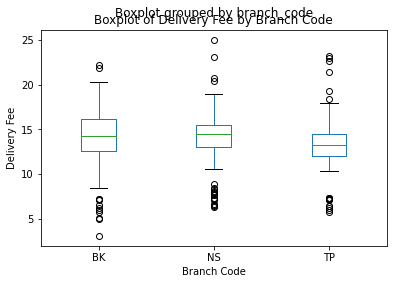

In [66]:
plt.figure(figsize=(10, 6))
outlier_df.boxplot(column='delivery_fee', by='branch_code', grid=False) #Creatign a boxplot for delivery_fee based on the branch_code
plt.title('Boxplot of Delivery Fee by Branch Code')
plt.xlabel('Branch Code')
plt.ylabel('Delivery Fee')
plt.xticks()
plt.show()

The distribution of delivery fees among the three branch codes—BK, NS, and TP—is shown in the boxplot. The median delivery fee for each branch is roughly 14–15, with BK and NS having somewhat higher medians than TP. The interquartile range (IQR) of delivery_fee, varies from 11 to 18 for BK, 12 to 17 for NS, and 11 to 16 for TP. This range is largely stable between branches. For every branch, the whiskers, which show the range within 1.5 times the IQR from the quartiles, roughly span from 8 to 20. Interestingly, there are a considerable number of outliers in every branch. The outliers for BK and NS are mainly on the higher end, above 20, In contrast, TP displays a balanced distribution of outliers, with those outside of 8 and those over 18. These outliers point to sporadic departures from the usual range of delivery fees, which calls for additional research to determine the root causes. With a few noteworthy outliers, the data generally shows that the branches' delivery costs are consistent.

pre-trained linear regression model is loaded from the file delivery_fee_model.pkl using joblib.load(), for predicting delivery fees.

In [67]:
#Loading the model
model = load('delivery_fee_model.pkl')

In [68]:
# preparing the weekend and time_of_day columns for outlier dataframe
outlier_df['weekend'] = outlier_df['date'].apply(lambda x: pd.to_datetime(x).dayofweek >= 5)
outlier_df['time_of_day'] = outlier_df['time'].apply(calc_timeOfDay)

Dummy variables are created for the branch_code column to represent branch codes as numerical features.

In [69]:
# Generate one hot encodings for each categorical variable in branch_code
onehot = pd.get_dummies(outlier_df['branch_code'], prefix='branch_code')
# Concatenate the one hot encodings with the original df
outlier_df = pd.concat([outlier_df, onehot], axis=1)

rearranging all the columns in the DataFrame to match the order of features used during model training.

In [70]:
#defining all the features required to predict delivery_fee
expected_columns = ['weekend', 'time_of_day', 'distance_to_customer_KM', 'branch_code_BK','branch_code_NS', 'branch_code_TP', 'customerHasloyalty?']


In [71]:
#filtering all the features from the outlier_df
X_outliers = outlier_df[expected_columns]

Using the trained model from corrected missing value file to predict delivery fees for the outlier dataframe.

In [72]:
#predicting delivery_fee from the model and storing it to predicted_delivery_fee
outlier_df['predicted_delivery_fee'] = model.predict(X_outliers)

# round predicted_delivery_fee to 7 decimal places
outlier_df['predicted_delivery_fee'] = outlier_df['predicted_delivery_fee'].round(7)

Calculating the residuals by subtracting the predicted delivery fees from the actual delivery fees.

In [73]:
# Calculating residuals
outlier_df['residuals'] = outlier_df['delivery_fee'] - outlier_df['predicted_delivery_fee']


identifying outliers based on the mean and standard deviation of the residuals by calculating thresholds.

In [74]:
# Defining upper and lower thresholds for identifying outliers
upper_threshold = np.mean(outlier_df['delivery_fee']) + 1.5 * np.std(outlier_df['residuals'])
lower_threshold = np.mean(outlier_df['delivery_fee']) - 1.5 * np.std(outlier_df['residuals'])

In [75]:
#identifying all the outliers that are outside the upper and lower threshold values
outliers = outlier_df[(outlier_df['delivery_fee'] > upper_threshold) | (outlier_df['delivery_fee'] < lower_threshold)]

In [76]:
# Removing outliers from the DataFrame
outlier_free_df = outlier_df[(outlier_df['delivery_fee'] <= upper_threshold) & (outlier_df['delivery_fee'] >= lower_threshold)]

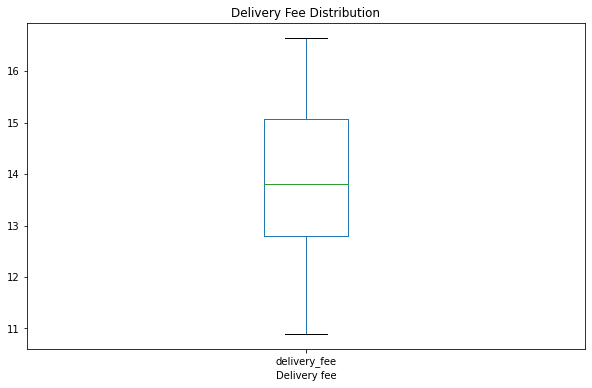

In [77]:
# creating a box plot after removing the outliers
plt.figure(figsize=(10, 6))
outlier_free_df.boxplot(column="delivery_fee",grid=False)
plt.title('Delivery Fee Distribution')
plt.xlabel('Delivery fee')
plt.xticks()
plt.show()

In [78]:
# Writing the outlier free dataframe to the csv file
outlier_free_df[final_features].to_csv("output/109_outlier_data_solution.csv", index=False) 

## Task 2

### Data Exploration

Loading the required libraries and the dataset and explore its statistical properties, Distribution of the data and check for the Types of the columns.

In [79]:
info = "suburb_info.xlsx"
suburb_info = pd.read_excel(info)

In [80]:
print(suburb_info.head())

       suburb  number_of_houses  number_of_units   municipality aus_born_perc  \
0  ABBOTSFORD              2304             4706          Yarra           68%   
1  ABERFELDIE              1410              453  Moonee Valley           81%   
2   ALBANVALE              1897              138       Brimbank           46%   
3      ALBION              1389             1392       Brimbank           52%   
4  ALPHINGTON              1729             1099        Darebin           73%   

  median_income median_house_price  population  
0        $1,797         $1,299,400        4025  
1        $1,571         $1,926,600       22442  
2          $907           $594,200       54005  
3          $929           $739,100       30677  
4        $1,538         $1,729,600        9227  


In [81]:
suburb_info.describe()

number_of_houses  number_of_units    population
count        202.000000       202.000000    202.000000
mean        4155.767327      2480.410891  18659.311881
std         3400.864988      3132.684712   9604.187282
min          283.000000        60.000000    170.000000
25%         1973.500000       620.500000  12063.000000
50%         3256.500000      1603.000000  17583.000000
75%         5518.500000      3089.000000  24045.000000
max        23338.000000     24380.000000  54005.000000

In [82]:
print(suburb_info.dtypes) #Checking for the Types
print(suburb_info.isnull().sum()) # Checking for the Null values from the dataset

suburb                object
number_of_houses       int64
number_of_units        int64
municipality          object
aus_born_perc         object
median_income         object
median_house_price    object
population             int64
dtype: object
suburb                0
number_of_houses      0
number_of_units       0
municipality          0
aus_born_perc         0
median_income         0
median_house_price    0
population            0
dtype: int64


In the dataset we are having some anamolies that contains $, % symbols in the aus_born_perc, median_house_price, median_income, and these are in the object datatype. so, we have to remove those anamolies and convert it into suitable datatype for any linear transformations.

In [83]:
suburb_info['aus_born_perc'] = suburb_info['aus_born_perc'].str.replace('%', '').astype(float)
suburb_info['median_income'] = suburb_info['median_income'].str.replace('$', '').str.replace(',', '').astype(float)
suburb_info['median_house_price'] = suburb_info['median_house_price'].str.replace('$', '').str.replace(',', '').astype(float)
print(suburb_info.dtypes)

suburb                 object
number_of_houses        int64
number_of_units         int64
municipality           object
aus_born_perc         float64
median_income         float64
median_house_price    float64
population              int64
dtype: object


<ipython-input-83-ca2e1ca003fc>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  suburb_info['median_income'] = suburb_info['median_income'].str.replace('$', '').str.replace(',', '').astype(float)
<ipython-input-83-ca2e1ca003fc>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  suburb_info['median_house_price'] = suburb_info['median_house_price'].str.replace('$', '').str.replace(',', '').astype(float)


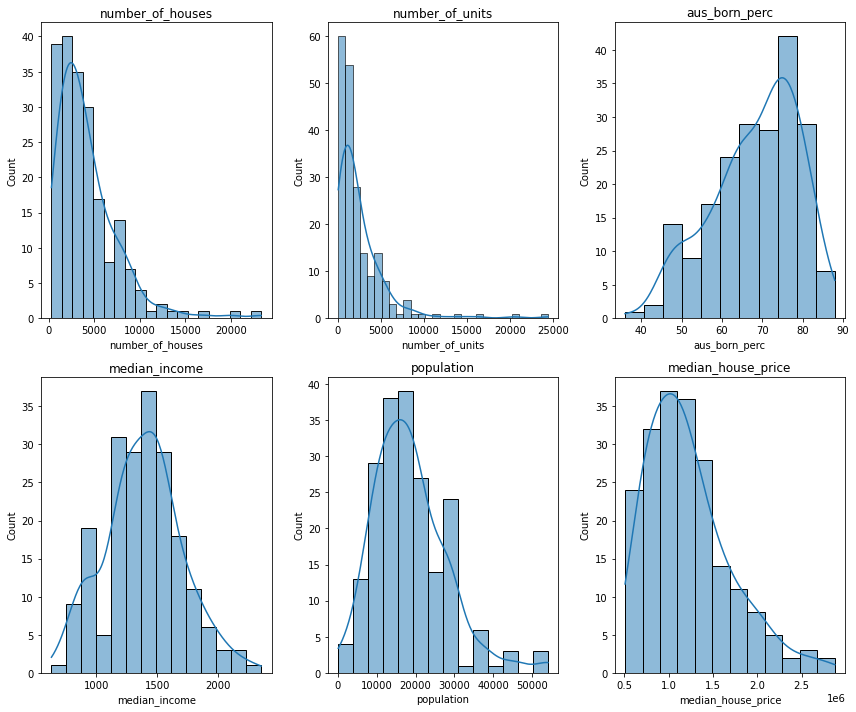

In [84]:

plt.figure(figsize=(12, 10))
for i, column in enumerate(['number_of_houses', 'number_of_units', 'aus_born_perc', 'median_income', 'population', 'median_house_price']):
    plt.subplot(2, 3, i+1)
    sns.histplot(suburb_info[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()

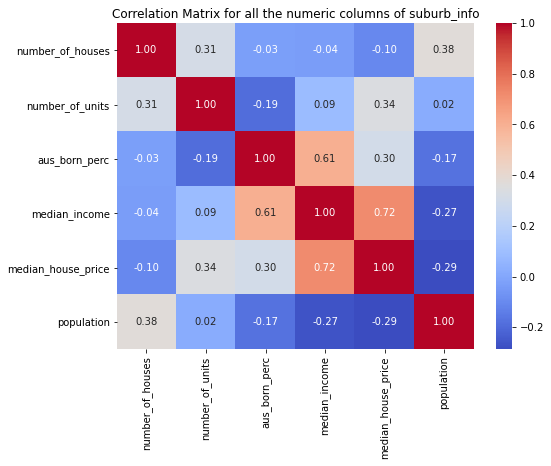

In [85]:
# Visualization of correlation matrix

corr_matrix = suburb_info.loc[:, ~suburb_info.columns.isin(['suburb', 'municipality'])].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for all the numeric columns of suburb_info')
plt.show()

Among these features, median_income exhibits the strongest positive correlation (0.72) with median_house_price, indicating a notable tendency for higher median_house_price in areas with higher median_income. Additionally, aus_born_perc demonstrates a moderate positive correlation (0.30), implying a modest association between a higher percentage of Australian-born residents and higher median_house_price. Similarly, number_of_units and population exhibit positive correlations of 0.34 and -0.29, respectively.

# **Normalization/Transformation**

**Z-Score Standardization**

In [86]:
suburb_info.describe()

number_of_houses  number_of_units  aus_born_perc  median_income  \
count        202.000000       202.000000     202.000000     202.000000   
mean        4155.767327      2480.410891      68.366337    1387.935644   
std         3400.864988      3132.684712      10.761293     317.841321   
min          283.000000        60.000000      36.000000     633.000000   
25%         1973.500000       620.500000      62.000000    1182.250000   
50%         3256.500000      1603.000000      70.000000    1393.000000   
75%         5518.500000      3089.000000      77.000000    1560.000000   
max        23338.000000     24380.000000      88.000000    2352.000000   

       median_house_price    population  
count        2.020000e+02    202.000000  
mean         1.218817e+06  18659.311881  
std          4.716807e+05   9604.187282  
min          5.072000e+05    170.000000  
25%          8.706750e+05  12063.000000  
50%          1.134500e+06  17583.000000  
75%          1.467550e+06  24045.000000  
max          2.875800e+06  54005.000000

While scaling may not be essential for attributes like Population, number_of_houses, and Aus_born_perc due to their inherent measures or bounded nature, applying scaling uniformly across all columns can ensure consistency and aid in model interpretation. Standardizing the data can also enhance the performance of the linear model by preventing any single feature from dominating due to its scale and maintaining relative relationships between attributes like median_income and median_house_price, despite their dollar measurement. Therefore, while not strictly necessary for all attributes, scaling promotes consistency and optimizes model performance.

In [87]:
std_scale = preprocessing.StandardScaler().fit(suburb_info[['median_income', 'median_house_price','aus_born_perc','number_of_houses',	'number_of_units','population'	]])
std = std_scale.transform(suburb_info[['median_income', 'median_house_price','aus_born_perc','number_of_houses',	'number_of_units','population']])

suburb_info['median_income_scaled'] = std[:,0]
suburb_info['median_house_price_scaled'] = std[:,1]
suburb_info['aus_born_perc_scaled'] = std[:,2]
suburb_info['number_of_houses_scaled'] = std[:,3]
suburb_info['number_of_units_scaled'] = std[:,4]
suburb_info['population_scaled'] = std[:,5]

suburb_info[0:5]

suburb  number_of_houses  number_of_units   municipality  \
0  ABBOTSFORD              2304             4706          Yarra   
1  ABERFELDIE              1410              453  Moonee Valley   
2   ALBANVALE              1897              138       Brimbank   
3      ALBION              1389             1392       Brimbank   
4  ALPHINGTON              1729             1099        Darebin   

   aus_born_perc  median_income  median_house_price  population  \
0           68.0         1797.0           1299400.0        4025   
1           81.0         1571.0           1926600.0       22442   
2           46.0          907.0            594200.0       54005   
3           52.0          929.0            739100.0       30677   
4           73.0         1538.0           1729600.0        9227   

   median_income_scaled  median_house_price_scaled  aus_born_perc_scaled  \
0              1.290206                   0.171267             -0.034127   
1              0.577392                   1.504284              1.176908   
2             -1.516891                  -1.327527             -2.083570   
3             -1.447502                  -1.019564             -1.524631   
4              0.473309                   1.085591              0.431656   

   number_of_houses_scaled  number_of_units_scaled  population_scaled  
0                -0.545852                0.712207          -1.527529  
1                -0.809379               -0.648788           0.394837  
2                -0.665824               -0.749590           3.689381  
3                -0.815569               -0.348300           1.254406  
4                -0.715346               -0.442063          -0.984544

On performing the Z-Score Standardization on the columns. the identified columns are standardized  

In [88]:
print('Mean after standardisation:\median_income_scaled = {:.2f}, median_house_price_scaled = {:.2f}, aus_born_perc_scaled = {:.2f}, number_of_houses_scaled = {:.2f}, number_of_units_scaled = {:.2f}, population_scaled = {:.2f}'
      .format(suburb_info['median_income_scaled'].mean(), suburb_info['median_house_price_scaled'].mean(), suburb_info['aus_born_perc_scaled'].mean(), suburb_info['number_of_houses_scaled'].mean(), suburb_info['number_of_units_scaled'].mean(), suburb_info['population_scaled'].mean()))
print('\nStandard deviation after standardisation:\median_income_scaled = {:.2f}, median_house_price_scaled = {:.2f}, aus_born_perc_scaled = {:.2f}, number_of_houses_scaled = {:.2f}, number_of_units_scaled = {:.2f}, population_scaled = {:.2f}'
      .format(suburb_info['median_income_scaled'].std(), suburb_info['median_house_price_scaled'].std(), suburb_info['aus_born_perc_scaled'].std(), suburb_info['number_of_houses_scaled'].std(), suburb_info['number_of_units_scaled'].std(), suburb_info['population_scaled'].std()))

Mean after standardisation:\median_income_scaled = -0.00, median_house_price_scaled = -0.00, aus_born_perc_scaled = 0.00, number_of_houses_scaled = -0.00, number_of_units_scaled = -0.00, population_scaled = 0.00

Standard deviation after standardisation:\median_income_scaled = 1.00, median_house_price_scaled = 1.00, aus_born_perc_scaled = 1.00, number_of_houses_scaled = 1.00, number_of_units_scaled = 1.00, population_scaled = 1.00


(<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>)

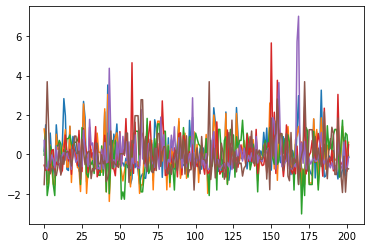

In [89]:
%matplotlib inline
suburb_info['median_house_price_scaled'].plot(),suburb_info['median_income_scaled'].plot(),suburb_info['aus_born_perc_scaled'].plot(),suburb_info['number_of_houses_scaled'].plot(),suburb_info['number_of_units_scaled'].plot(),suburb_info['population_scaled'].plot()

**Min Max Standardization**

Studying the affect of Min max Standardization methods by making the values of Minimum to 0 and Maximum to 1. Here we are using median_house_price, median_income and aus_born_perc columns for reshaping.

In [90]:
suburb_minmax = preprocessing.MinMaxScaler().fit(suburb_info[['median_house_price','median_income','aus_born_perc','number_of_houses',	'number_of_units','population']])
data_minmax = suburb_minmax.transform(suburb_info[['median_house_price','median_income','aus_born_perc','number_of_houses',	'number_of_units','population']])
suburb_info['median_income_minmax'] = data_minmax[:,1]
suburb_info['median_house_price_minmax'] = data_minmax[:,0]
suburb_info['aus_born_perc_minmax'] = data_minmax[:,2]
suburb_info['number_of_houses_minmax'] = data_minmax[:,3]
suburb_info['number_of_units_minmax'] = data_minmax[:,4]
suburb_info['population_minmax'] = data_minmax[:,5]
data_minmax[0:5]

array([[0.33445917, 0.67713787, 0.61538462, 0.08765994, 0.19103618,
        0.07160769],
       [0.59925695, 0.54566608, 0.86538462, 0.04888311, 0.01615954,
        0.41370855],
       [0.03673056, 0.159395  , 0.19230769, 0.07000651, 0.00320724,
        1.        ],
       [0.09790594, 0.17219314, 0.30769231, 0.04797224, 0.05476974,
        0.56667595],
       [0.51608545, 0.52646888, 0.71153846, 0.06271958, 0.04272204,
        0.16823628]])

As we can clearly see the below section for the result of min max Standardization, the columns that we have choosen is normalized to minimum value to 0 and maximum value to 1.

In [91]:
print('Min-value after min-max scaling:\median_house_price = {:.2f}, median_income = {:.2f}, aus_born_perc = {:.2f}'
      .format(data_minmax[:,0].min(), data_minmax[:,1].min(), data_minmax[:,2].min()))
print('\nMax-value after min-max scaling:\median_house_price = {:.2f}, median_income = {:.2f}, aus_born_perc = {:.2f}'
      .format(data_minmax[:,0].max(), data_minmax[:,1].max(), data_minmax[:,2].max()))

Min-value after min-max scaling:\median_house_price = 0.00, median_income = 0.00, aus_born_perc = 0.00

Max-value after min-max scaling:\median_house_price = 1.00, median_income = 1.00, aus_born_perc = 1.00


Comparing Z-score and MinMax Standardization  

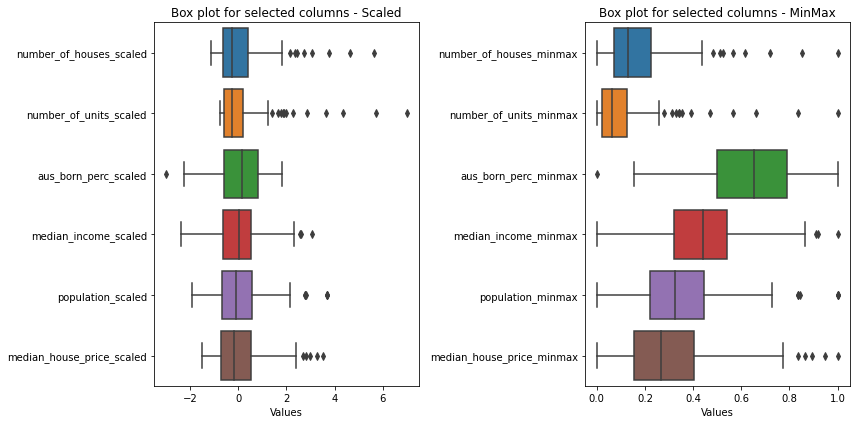

Count of outliers for each column: Z-score
number_of_houses_scaled       8
number_of_units_scaled       12
aus_born_perc_scaled          1
median_income_scaled          3
population_scaled             6
median_house_price_scaled     5
dtype: int64
Count of outliers for each column: MinMax
number_of_houses_minmax       8
number_of_units_minmax       12
aus_born_perc_minmax          1
median_income_minmax          3
population_minmax             6
median_house_price_minmax     5
dtype: int64


In [92]:
selected_columns1 = ['number_of_houses_scaled', 'number_of_units_scaled', 'aus_born_perc_scaled', 'median_income_scaled', 'population_scaled', 'median_house_price_scaled']
selected_columns2 = ['number_of_houses_minmax', 'number_of_units_minmax', 'aus_born_perc_minmax', 'median_income_minmax', 'population_minmax', 'median_house_price_minmax']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.boxplot(data=suburb_info[selected_columns1], orient="h", ax=axes[0])
axes[0].set_xlabel("Values")
axes[0].set_title("Box plot for selected columns - Scaled")

sns.boxplot(data=suburb_info[selected_columns2], orient="h", ax=axes[1])
axes[1].set_xlabel("Values")
axes[1].set_title("Box plot for selected columns - MinMax")

plt.tight_layout()
plt.show()

Q1 = suburb_info[selected_columns1].quantile(0.25)
Q3 = suburb_info[selected_columns1].quantile(0.75)
IQR = Q3 - Q1
outliers = ((suburb_info[selected_columns1] < (Q1 - 1.5 * IQR)) | (suburb_info[selected_columns1] > (Q3 + 1.5 * IQR)))

# Count outliers for each column
outlier_counts = outliers.sum()
print("Count of outliers for each column: Z-score")
print(outlier_counts)

Q11 = suburb_info[selected_columns2].quantile(0.25)
Q33 = suburb_info[selected_columns2].quantile(0.75)
IQRR = Q33 - Q11
outlier = ((suburb_info[selected_columns2] < (Q11 - 1.5 * IQRR)) | (suburb_info[selected_columns2] > (Q33 + 1.5 * IQRR)))

# Count outliers for each column
outlier_count = outlier.sum()
print("Count of outliers for each column: MinMax")
print(outlier_count)

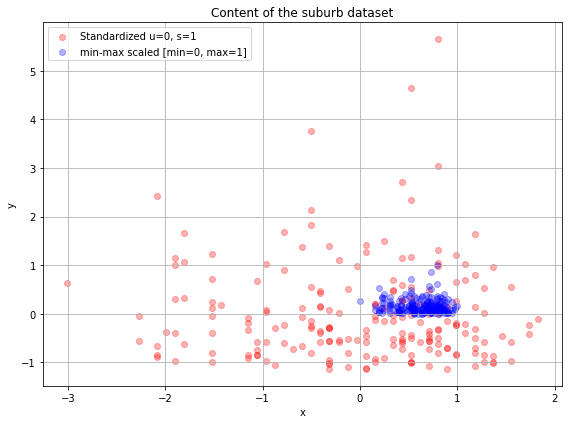

In [93]:
def plot():
    f = plt.figure(figsize=(8,6))

    plt.scatter(std[:,2], std[:,3], color='red',
             label='Standardized u=0, s=1', alpha=0.3)

    plt.scatter(data_minmax[:,2], data_minmax[:,3],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Content of the suburb dataset')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

Z-score standardization is robust to outliers beacuse it relies on the mean and standardization of the data, which are less sensitive to outliers compared to the range used in the minmax scaling. it maintains the shape of the distribution.

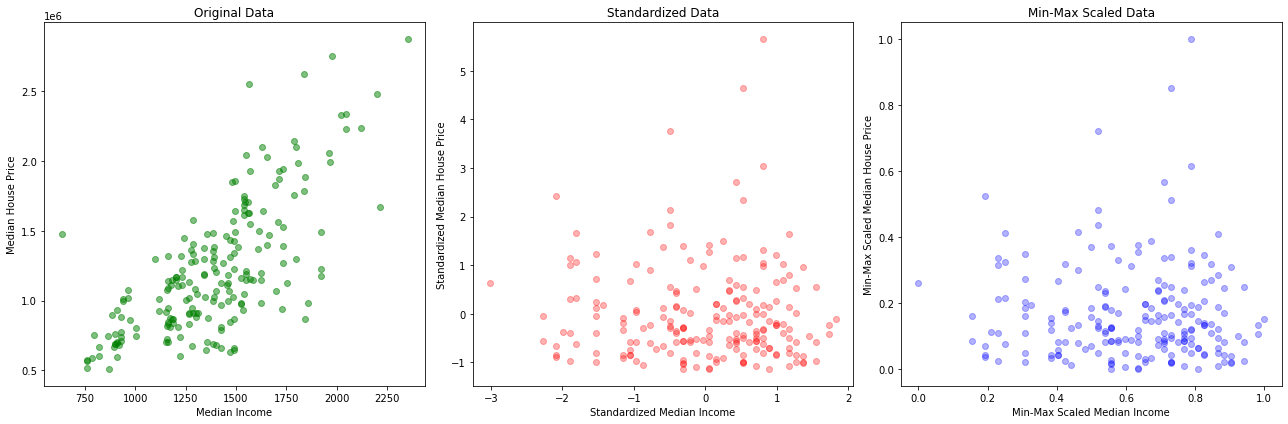

In [94]:
import matplotlib.pyplot as plt

def plot():
    f, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].scatter(suburb_info['median_income'], suburb_info['median_house_price'],
                   color='green', label='input scale', alpha=0.5)
    axs[0].set_title('Original Data')
    axs[0].set_xlabel('Median Income')
    axs[0].set_ylabel('Median House Price')

    axs[1].scatter(std[:, 2], std[:, 3], color='red',
                   label='Standardized u=0, s=1', alpha=0.3)
    axs[1].set_title('Standardized Data')
    axs[1].set_xlabel('Standardized Median Income')
    axs[1].set_ylabel('Standardized Median House Price')

    axs[2].scatter(data_minmax[:, 2], data_minmax[:, 3],
                   color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)
    axs[2].set_title('Min-Max Scaled Data')
    axs[2].set_xlabel('Min-Max Scaled Median Income')
    axs[2].set_ylabel('Min-Max Scaled Median House Price')

    plt.tight_layout()

plot()
plt.show()


### Transformations:

In [95]:
suburb_info.head()

suburb  number_of_houses  number_of_units   municipality  \
0  ABBOTSFORD              2304             4706          Yarra   
1  ABERFELDIE              1410              453  Moonee Valley   
2   ALBANVALE              1897              138       Brimbank   
3      ALBION              1389             1392       Brimbank   
4  ALPHINGTON              1729             1099        Darebin   

   aus_born_perc  median_income  median_house_price  population  \
0           68.0         1797.0           1299400.0        4025   
1           81.0         1571.0           1926600.0       22442   
2           46.0          907.0            594200.0       54005   
3           52.0          929.0            739100.0       30677   
4           73.0         1538.0           1729600.0        9227   

   median_income_scaled  median_house_price_scaled  aus_born_perc_scaled  \
0              1.290206                   0.171267             -0.034127   
1              0.577392                   1.504284              1.176908   
2             -1.516891                  -1.327527             -2.083570   
3             -1.447502                  -1.019564             -1.524631   
4              0.473309                   1.085591              0.431656   

   number_of_houses_scaled  number_of_units_scaled  population_scaled  \
0                -0.545852                0.712207          -1.527529   
1                -0.809379               -0.648788           0.394837   
2                -0.665824               -0.749590           3.689381   
3                -0.815569               -0.348300           1.254406   
4                -0.715346               -0.442063          -0.984544   

   median_income_minmax  median_house_price_minmax  aus_born_perc_minmax  \
0              0.677138                   0.334459              0.615385   
1              0.545666                   0.599257              0.865385   
2              0.159395                   0.036731              0.192308   
3              0.172193                   0.097906              0.307692   
4              0.526469                   0.516085              0.711538   

   number_of_houses_minmax  number_of_units_minmax  population_minmax  
0                 0.087660                0.191036           0.071608  
1                 0.048883                0.016160           0.413709  
2                 0.070007                0.003207           1.000000  
3                 0.047972                0.054770           0.566676  
4                 0.062720                0.042722           0.168236

As number_of_houses, number_of_units, population represent counts and exhibit a wide range of values and having much karger values compared to "aus_born_perc". such differences in scales can affect the performance of linear models. features with larger scales might affect the model, As these columns have a positive skew distribution, therfore transformation is required to stabalize the variance and make the distribution more symmetric. Lets us try to study the affects of different transformation methods on these columns.

In [96]:
#Root Transformation
suburb_info['sqrt_number_of_houses'] = suburb_info['number_of_houses'].apply(np.sqrt)
suburb_info['sqrt_number_of_units'] = suburb_info['number_of_units'].apply(np.sqrt)
suburb_info['sqrt_population'] = suburb_info['population'].apply(np.sqrt)

In [97]:
#Square Power Transformation
suburb_info['squared_number_of_houses'] = suburb_info['number_of_houses'] ** 2
suburb_info['squared_number_of_units'] = suburb_info['number_of_units'] ** 2
suburb_info['squared_population'] = suburb_info['population'] ** 2

In [98]:
import math
#Log Transformation
suburb_info['log_number_of_houses'] = suburb_info['number_of_houses'].apply(lambda x: math.log(x + 1))
suburb_info['log_number_of_units'] = suburb_info['number_of_units'].apply(lambda x: math.log(x + 1))
suburb_info['log_population'] = suburb_info['population'].apply(lambda x: math.log(x + 1))

In [99]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for the specified columns
suburb_info = remove_outliers(suburb_info, 'number_of_houses_minmax')
suburb_info = remove_outliers(suburb_info, 'number_of_units_minmax')
suburb_info = remove_outliers(suburb_info, 'population_minmax')

In [100]:
from scipy.stats import boxcox
#Box-Cox Transformation
suburb_info['boxcox_number_of_houses'], _ = boxcox(suburb_info['number_of_houses'])
suburb_info['boxcox_number_of_units'], _ = boxcox(suburb_info['number_of_units'] + 1)
suburb_info['boxcox_population'], _ = boxcox(suburb_info['population'])

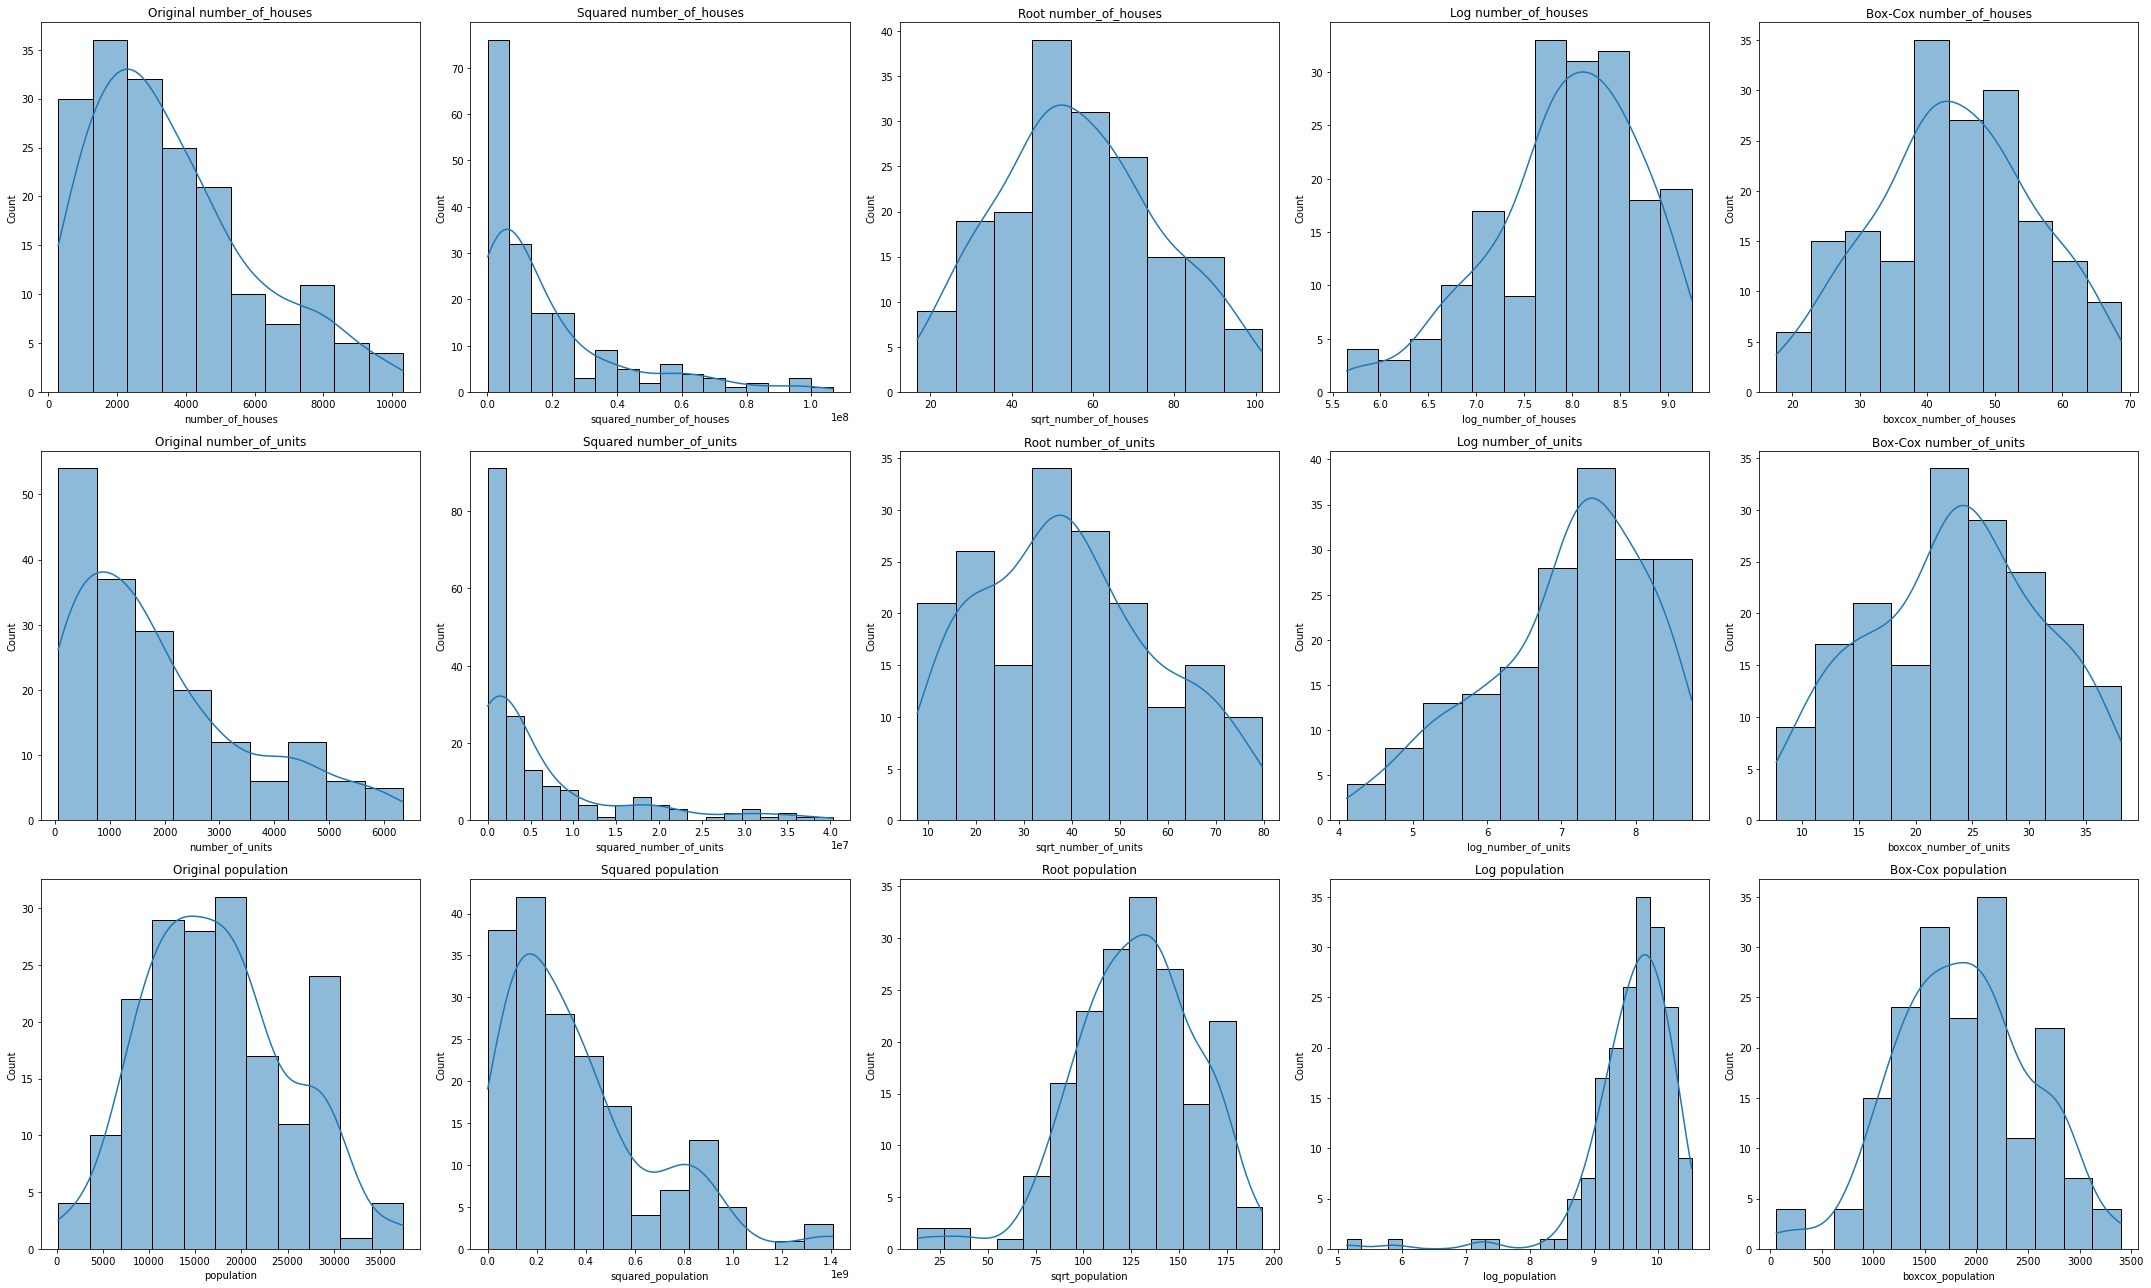

In [101]:
plt.figure(figsize=(30, 18))

# Plot the distributions horizontally

# Original distributions
plt.subplot(3, 5, 1)
sns.histplot(suburb_info['number_of_houses'], kde=True)
plt.title('Original number_of_houses')

plt.subplot(3, 5, 6)
sns.histplot(suburb_info['number_of_units'], kde=True)
plt.title('Original number_of_units')

plt.subplot(3, 5, 11)
sns.histplot(suburb_info['population'], kde=True)
plt.title('Original population')

# Square Power Transformed distributions
plt.subplot(3, 5, 2)
sns.histplot(suburb_info['squared_number_of_houses'], kde=True)
plt.title('Squared number_of_houses')

plt.subplot(3, 5, 7)
sns.histplot(suburb_info['squared_number_of_units'], kde=True)
plt.title('Squared number_of_units')

plt.subplot(3, 5, 12)
sns.histplot(suburb_info['squared_population'], kde=True)
plt.title('Squared population')

# Root Transformed distributions
plt.subplot(3, 5, 3)
sns.histplot(suburb_info['sqrt_number_of_houses'], kde=True)
plt.title('Root number_of_houses')

plt.subplot(3, 5, 8)
sns.histplot(suburb_info['sqrt_number_of_units'], kde=True)
plt.title('Root number_of_units')

plt.subplot(3, 5, 13)
sns.histplot(suburb_info['sqrt_population'], kde=True)
plt.title('Root population')

# Log Transformed distributions
plt.subplot(3, 5, 4)
sns.histplot(suburb_info['log_number_of_houses'], kde=True)
plt.title('Log number_of_houses')

plt.subplot(3, 5, 9)
sns.histplot(suburb_info['log_number_of_units'], kde=True)
plt.title('Log number_of_units')

plt.subplot(3, 5, 14)
sns.histplot(suburb_info['log_population'], kde=True)
plt.title('Log population')

# Box-Cox Transformed distributions
plt.subplot(3, 5, 5)
sns.histplot(suburb_info['boxcox_number_of_houses'], kde=True)
plt.title('Box-Cox number_of_houses')

plt.subplot(3, 5, 10)
sns.histplot(suburb_info['boxcox_number_of_units'], kde=True)
plt.title('Box-Cox number_of_units')

plt.subplot(3, 5, 15)
sns.histplot(suburb_info['boxcox_population'], kde=True)
plt.title('Box-Cox population')

plt.tight_layout()
plt.show()

* For squared transformations, we can see that the transformation produces a
large positive skew. This large skew would make it an unsuitable option when building the linear regression model
* The same can be said for root transformation. As we can see from feature number_of_houses and number_of_units, there is also a large positive skew which can create bias within the model
* For log transformation, we can see a large negative skew in the population feature, making this transformation not suitable
* The transformation that performs the changes as we like is the box-cox transformation as it makes the distribution of the dataset most resemble a normal distribution, stabilising the variance and normalising the skewed data. This improves the performance and accuracy of the linear regression model when constructed.